In [1]:
from math import sqrt
from random import random, randrange, seed

In [2]:
import matplotlib
import seaborn
import pandas

In [3]:
from models import *
from methods import *

In [4]:
seaborn.set(style="darkgrid")
matplotlib.rcParams["figure.dpi"] = 300
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.serif"] = ["Times New Roman"]

In [5]:
seed(0)

The functions `test_correction`, `test_interview`, and `test_coordination` in the following section each set up a random matching scenario in the corresponding model, according to the standard setting described in Section 5 of the paper.

In [6]:
num_professions = 2  # This is a constant; changing it requires
                     # further code modifications
num_agents = 100
prof1 = 50
prof2 = num_agents - prof1
professions = [0] * prof1 + [1] * prof2
random_samples = 1000

def _distribute_caps_and_jobs(num_localities):
    assert num_localities <= num_agents
        
    # Distribute caps adding up to `num_agents` over all localities,
    # ensuring that each locality has at least one space
    locality_caps = [1 for _ in range(num_localities)]
    for _ in range(num_agents - num_localities):
        locality_caps[randrange(len(locality_caps))] += 1

    # Job numbers add up to the cap per locality, but `prof1` jobs for
    # profession 1 and `prof2` jobs for profession 2 are randomly
    # distributed inside these bounds.
    prof1_jobs = prof1  # Remaining jobs to distribute
    prof2_jobs = prof2
    
    job_numbers = []
    for cap in locality_caps:
        p1, p2 = 0, 0
        for _ in range(cap):
            if random() < prof1_jobs / (prof1_jobs + prof2_jobs):
                p1 += 1
                prof1_jobs -= 1
                assert prof1_jobs >= 0
            else:
                p2 += 1
                prof2_jobs -= 1
                assert prof2_jobs >= 0
        job_numbers.append((p1, p2))
        
    return locality_caps, job_numbers
    
def test_correction(num_localities):
    locality_caps, job_numbers = \
        _distribute_caps_and_jobs(num_localities)
    qualification_probabilities = \
        [[random()] * num_localities for _ in range(num_agents)]
    correction_functions = []
    for p1, p2 in job_numbers:
        # The default parameters in the lambdas are never used, but are
        # a way of getting Python's peculiar binding behavior to work.
        # See https://docs.python.org/3/faq/programming.html#why-do-
        # lambdas-defined-in-a-loop-with-different-values-all-return-
        # the-same-result for more information.
        correction_functions.append((lambda x, P1=p1: min(x, P1),
                                     lambda x, P2=p2: min(x, P2)))
    model = RetroactiveCorrectionModel(num_agents, locality_caps,
                                       num_professions, professions,
                                       qualification_probabilities,
                                       correction_functions,
                                       random_samples)
    return model

def test_interview(num_localities):
    locality_caps, job_numbers = \
        _distribute_caps_and_jobs(num_localities)
    compatibility_probabilities = [random() for _ in range(num_agents)]
    model = InterviewModel(num_agents, locality_caps, num_professions,
                           professions, job_numbers,
                           compatibility_probabilities, random_samples)
    return model

def test_coordination(num_localities):
    locality_caps, job_numbers = \
        _distribute_caps_and_jobs(num_localities)
    locality_num_jobs = locality_caps
    compatibility_probabilities = []
    for _ in range(prof1):
        competency = random()
        compatibility_probabilities.append(
            [[competency] * p1 + [0.] * p2 for p1, p2 in job_numbers])
    for _ in range(prof2):
        competency = random()
        compatibility_probabilities.append(
            [[0.] * p1 + [competency] * p2 for p1, p2 in job_numbers])
    model = CoordinationModel(num_agents, locality_caps,
                              locality_num_jobs,
                              compatibility_probabilities,
                              random_samples)
    return model

settings = {"correction": test_correction, "interview": test_interview,
            "coordination": test_coordination}

In [7]:
data = []

def sample(setting, num_localities):
    m = settings[setting](num_localities)
    additive = additive_optimization(m)[1]
    greedy = greedy_algorithm(m)[1]
    datum = {}
    datum["number of localities"] = num_localities
    datum["additive"] = additive
    datum["greedy"] = greedy
    if additive > 0.0005:
        datum["greedy / additive"] = greedy / additive
    else:
        datum["greedy / additive"] = None
    datum["model"] = setting
    data.append(datum)
    return datum

In [8]:
from datetime import datetime
for _ in range(5):
    for num_localities in range(1, 21):
        for setting in settings:
            sample(setting, num_localities)
            print(datetime.now(), setting, num_localities, len(data))
from pickle import dumps
print(dumps(data))

Academic license - for non-commercial use only
2018-08-31 16:33:44.391412 correction 1 1
2018-08-31 16:35:58.843051 interview 1 2
2018-08-31 19:07:27.931843 coordination 1 3
2018-08-31 19:07:34.046254 correction 2 4
2018-08-31 19:08:20.059064 interview 2 5
2018-08-31 20:05:24.781659 coordination 2 6
2018-08-31 20:05:33.697495 correction 3 7
2018-08-31 20:06:29.473945 interview 3 8
2018-08-31 20:51:34.895032 coordination 3 9
2018-08-31 20:51:43.425224 correction 4 10
2018-08-31 20:52:29.185025 interview 4 11
2018-08-31 21:21:53.863375 coordination 4 12
2018-08-31 21:22:02.970960 correction 5 13
2018-08-31 21:22:47.717037 interview 5 14
2018-08-31 21:48:26.407005 coordination 5 15
2018-08-31 21:48:36.130068 correction 6 16
2018-08-31 21:49:15.891770 interview 6 17
2018-08-31 22:13:21.512055 coordination 6 18
2018-08-31 22:13:31.918345 correction 7 19
2018-08-31 22:14:09.159798 interview 7 20
2018-08-31 22:36:51.603104 coordination 7 21
2018-08-31 22:37:02.642616 correction 8 22
2018-08-3

2018-09-01 19:32:53.637557 interview 2 185
2018-09-01 20:22:18.499872 coordination 2 186
2018-09-01 20:22:25.357014 correction 3 187
2018-09-01 20:23:09.403267 interview 3 188
2018-09-01 20:53:04.828125 coordination 3 189
2018-09-01 20:53:11.757472 correction 4 190
2018-09-01 20:53:50.936303 interview 4 191
2018-09-01 21:18:49.759708 coordination 4 192
2018-09-01 21:18:57.003193 correction 5 193
2018-09-01 21:19:29.905046 interview 5 194
2018-09-01 21:40:37.119473 coordination 5 195
2018-09-01 21:40:44.817037 correction 6 196
2018-09-01 21:41:18.187110 interview 6 197
2018-09-01 21:59:37.987308 coordination 6 198
2018-09-01 21:59:46.450382 correction 7 199
2018-09-01 22:00:16.502702 interview 7 200
2018-09-01 22:17:36.166189 coordination 7 201
2018-09-01 22:17:45.549758 correction 8 202
2018-09-01 22:18:14.813298 interview 8 203
2018-09-01 22:35:27.326769 coordination 8 204
2018-09-01 22:35:37.317782 correction 9 205
2018-09-01 22:36:06.633001 interview 9 206
2018-09-01 22:52:03.931982

In [9]:
def _format_y(ratio):
    return f"{ratio-1:,.0%}"

def plot():
    d = pandas.DataFrame(data)
    y_min = 0.98
    y_max = 1.31
    g = seaborn.relplot(x="number of localities",
                        y="greedy / additive", col="model", data=d,
                        facet_kws={"ylim": (y_min, y_max)})
    for i, setting in enumerate(settings):
        up_outliers = {}
        down_outliers = {}
        for datum in data:
            if datum["model"] != setting:
                continue
            ga = datum['greedy / additive']
            nl = datum["number of localities"]
            if ga > y_max:
                if nl not in up_outliers:
                    up_outliers[nl] = []
                up_outliers[nl].append(ga)
            if ga < y_min:
                if nl not in down_outliers:
                    down_outliers[nl] = []
                down_outliers[nl].append(ga)
        ax = g.axes[0][i]
        ax.xaxis.set_major_locator(
            matplotlib.ticker.MultipleLocator(5))
        ax.yaxis.set_major_locator(
            matplotlib.ticker.MultipleLocator(0.05))
        vals = ax.get_yticks()
        ax.set_yticklabels([_format_y(x) for x in vals])
        ax.set_ylabel("improvement of greedy over additive")
        for nl in up_outliers:
            label = "\n".join(_format_y(ga) for ga in up_outliers[nl])
            ax.annotate(label, xy=(nl, y_max),
                        xytext=(nl, y_max-0.025),
                        horizontalalignment="center",
                        verticalalignment="top",
                        arrowprops={"color": "b", "arrowstyle": "->"})
        for nl in down_outliers:
            label = "\n".join(_format_y(ga) for ga in down_outliers[nl])
            ax.annotate(label, xy=(nl, y_min),
                        xytext=(nl, y_min+0.025),
                        horizontalalignment="center",
                        verticalalignment="bottom",
                        arrowprops={"color": "b", "arrowstyle": "->"})
    g.savefig("num_localities.pdf")

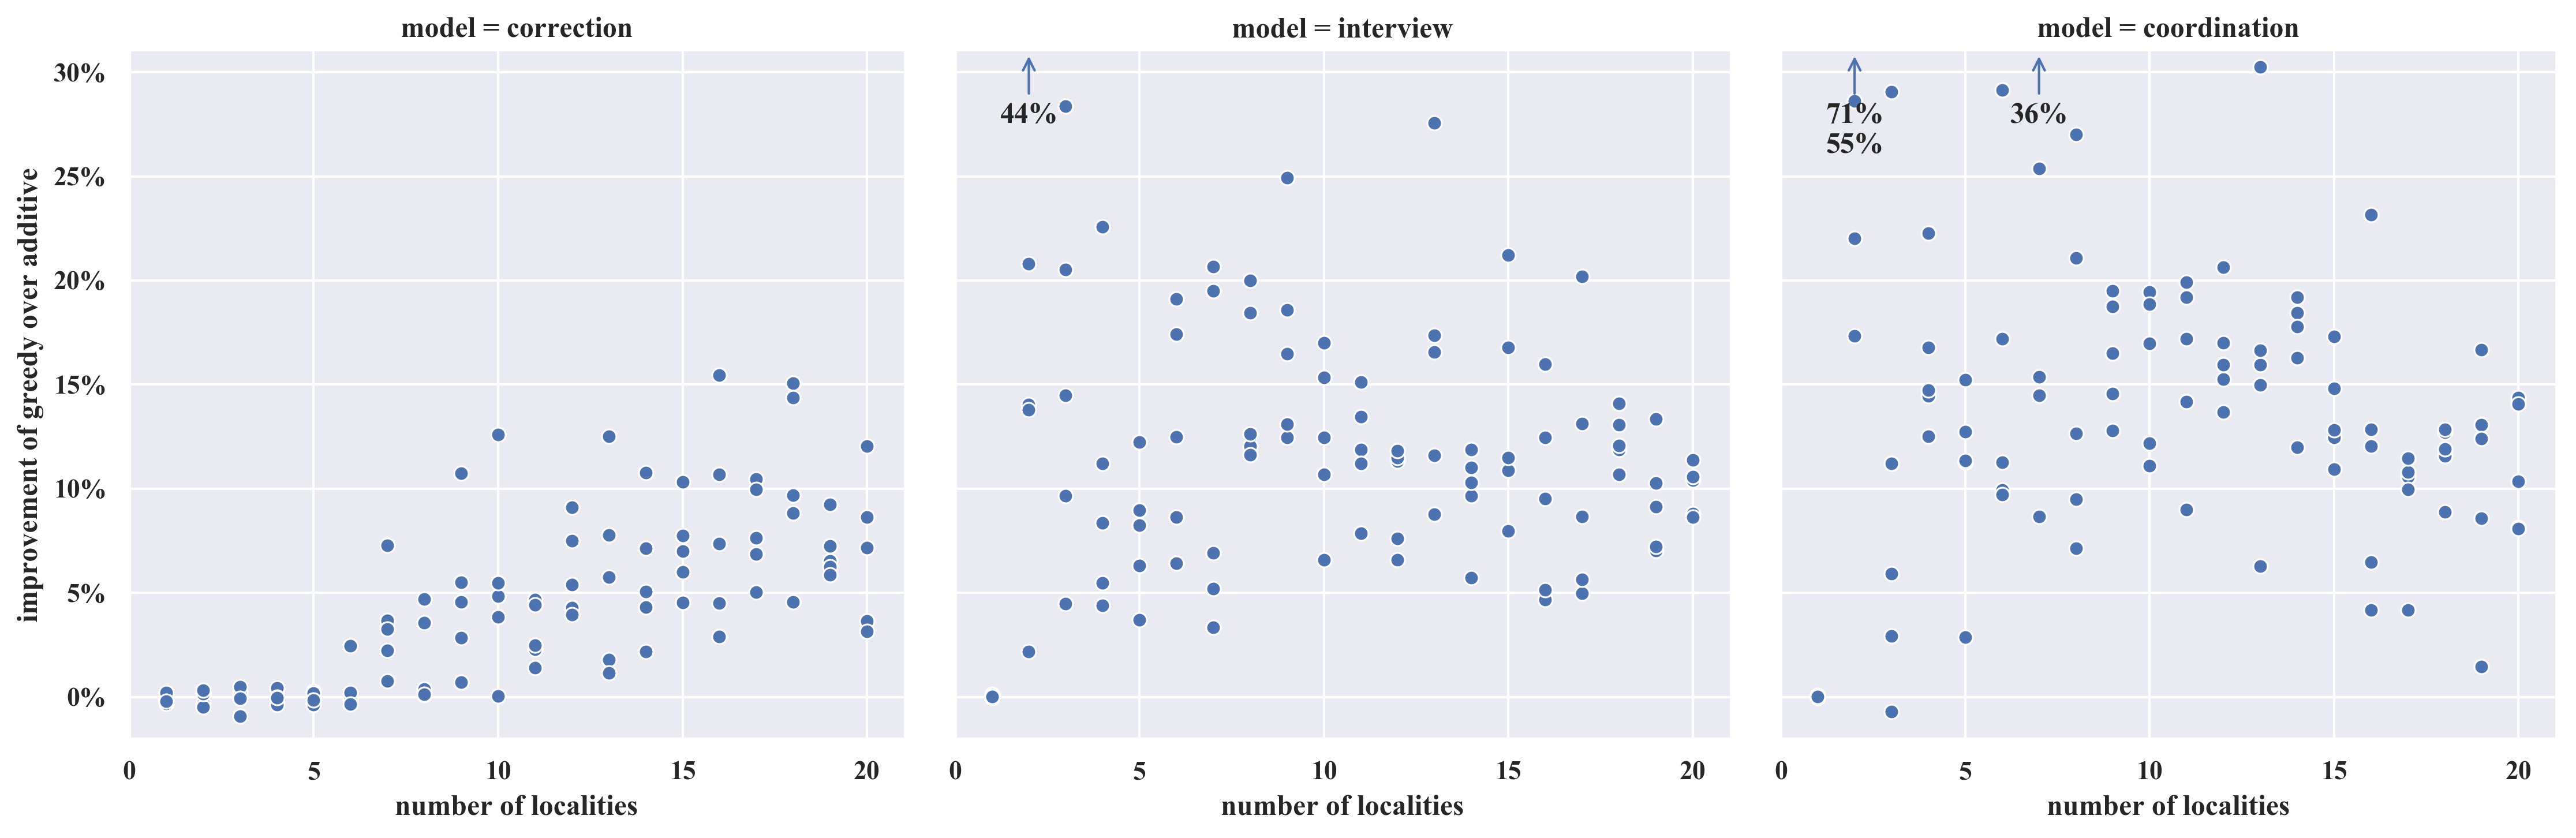

In [10]:
plot()